In [2]:
# import stuff based on the provided assignments

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
import pandas as pd
from pyfinance.options import BSM
from mpl_toolkits.mplot3d import Axes3D
from datar import f
from datar.dplyr import mutate, filter, if_else, pull, group_by, select
from pprint import pprint
import statsmodels.api as sm


In [3]:
"""function for testing frequencies and different strikes for all worksheets"""

def read_data(xls,worksheet):
    return pd.read_excel(xls, worksheet)
    

def format_data(df,expiry):
    """Convert into correct format"""
    df.rename(dict(zip(np.append(np.array(df.columns[0]), df.columns[-3:]), ['T', 'S', 'r', 'date'])), axis='columns', inplace=True)
    df = df.melt(id_vars=['T', 'r', 'S', 'date'], var_name="E").dropna()
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['name'] = df['E'].astype('str') + '-' + expiry
    
    df.rename({'value':'Cobs'}, axis='columns', inplace=True)
    df = df  >> mutate(r = f.r/100, Mat = f.T, T = f.T/252, S = f.S/1000, E = f.E/1000, Cobs = f.Cobs/1000)
    df['Mat'] = df['Mat'].astype('int')
    
    return df
    
def calculate_bs_greeks(row):
    """Calculate IV and using that as volatility find delta and vega"""
    S=row['S']
    E=row['E']
    r=row['r']
    T=row['T']
    Cobs=row['Cobs']
    
    starting_vol = .2
    bsm = BSM(S, E, T, r, starting_vol)
    iv = bsm.implied_vol(Cobs, precision=1.0e-6)
    
    bsm_iv = BSM(S, E, T, r, iv)
    
    delta = bsm_iv.delta()
    vega = bsm_iv.vega()
    
    return iv, delta, vega

def hedge(p_o, p_s, cobs, S, delta):
    option_gain = cobs - p_o
    stock_gain = -delta * (S - p_s['price'])
    error = option_gain + stock_gain
    
    return cobs, {'price':S, 'delta':delta}, error**2

def calculate_sheet_greeks(excel, sheet_name, sheetnr):
    day = str(sheet_name[3:5])
    month = str(sheet_name[5:7])
    year = str(sheet_name[7:11])
    expiry=year+month+day

    
    df = format_data(read_data(xls, sheet_name), expiry)
    greeks = df.apply(calculate_bs_greeks, axis=1, result_type='expand')
    df[['iv', 'delta', 'vega']] = greeks
    df['sheet'] = sheet_name
    df = df >> filter(0 < f.iv < 0.9)
    
    return df



In [4]:
xls = pd.ExcelFile('data/isx2010C.xls')
sheets = xls.sheet_names

sheet_order = [0,1,11,10,9,8,7,6,5,4,3,2]

all_sheets = []

for i in sheet_order:
    df = calculate_sheet_greeks(xls, sheets[i], i)
    all_sheets.append(df)

all_data = pd.concat(all_sheets)


/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()


In [5]:
def find_vega_hedges(data, date, option_mat):
    ok_hedges = data[(data['date'] == date) & (data['Mat'] > int(option_mat))]
    if len(ok_hedges) > 0:
        return 1
    return 0

def find_hedgeable_options(all_data):
    all_options = all_data['name'].unique()
    fully_hedgeable = []
    for option in all_options:

        days_hedged = 0
        # data for the chosen option that will be hedged
        initial_option_data = all_data[all_data['name'] == option]
        option_E = initial_option_data['E'].unique()[0]

        # options with same strike but not same
        available_hedges = all_data[(all_data['E'] == option_E) & (all_data['name'] != option)]

        # loop over days for the option
        for index, row in initial_option_data.iterrows():
            T,r,S,date,E,cobs,name, mat,iv,delta,vega, sheet = row

            has_hedge = find_vega_hedges(available_hedges, date, mat)

            days_hedged += has_hedge

        if days_hedged == len(initial_option_data):

            fully_hedgeable.append(option)
    return fully_hedgeable

fully_hedgeable = find_hedgeable_options(all_data)

In [6]:
observations = []
freq_min = 1
freq_max = 6
for option in fully_hedgeable:

    option_data = all_data[all_data['name'] == option]
    option_E = option_data['E'].iloc[0]

    available_hedges = all_data[(all_data['E'] == option_E) & (all_data['name'] != option)]


    # loop over days for the optio


    for freq in range(freq_min, freq_max):
        n = 1
        hedge_data = []
        for index, row in option_data.iterrows():
            T,r,S,date,E,cobs,name, mat,iv,delta,vega, sheet = row

            if n == freq:
                # from all options, choose data for those that are open at date and have longer maturity
                ok_hedges = available_hedges[(available_hedges['date'] == date) & (available_hedges['Mat'] > int(mat))]

                # choose hedge as the option with longest maturity
                selected_hedge = ok_hedges[ok_hedges['Mat'] == ok_hedges['Mat'].max()]['name'].values[0]
                n = 0

            # create hedging dataframe from option portfolio data and selected hedge
            #hedge_portfolio = [date,name, S, cobs, delta, vega] + selected_hedge[['name', 'Cobs', 'delta', 'vega']].values[0].tolist()
            n += 1
            hedge_information = all_data[(all_data['date'] == date) & (all_data['name'] == selected_hedge)]
            if not hedge_information.empty:
                hedge_portfolio = [date,name, S, cobs, delta, vega] + [selected_hedge] + hedge_information[['Cobs', 'delta', 'vega']].values[0].tolist()
                hedge_data.append(hedge_portfolio)


        hedge_df = pd.DataFrame(hedge_data, columns = ['date', 'name_p', 'S', 'cobs_p', 'delta_p', 'vega_p', 'name_h',  'cobs_h','delta_h','vega_h'])
        hedge_df['option_h_amount'] = hedge_df['vega_p'] / hedge_df['vega_h']
        hedge_df['option_h_amount'] = hedge_df.iloc[::5,:]['option_h_amount']

        hedge_df['stock_amount'] = hedge_df['delta_p'] - hedge_df['option_h_amount'] * hedge_df['delta_h']
        hedge_df['stock_amount'] = hedge_df.iloc[::5,:]['stock_amount']

        hedge_df[['option_h_amount','stock_amount']] = hedge_df[['option_h_amount','stock_amount']].ffill()

        hedge_df['return_option_h'] = hedge_df['option_h_amount'].shift(1) * hedge_df['cobs_h'].diff()
        hedge_df['return_stock'] = hedge_df['stock_amount'].shift(1) * hedge_df['S'].diff()

        hedge_df['return_p'] = -hedge_df['cobs_p'].diff() + hedge_df['return_stock'] + hedge_df['return_option_h']
        s_start = hedge_df['S'].iloc[0]
        s_end = hedge_df['S'].iloc[-1]
        s_mean = hedge_df['S'].mean()
        strike = option_E
        mse = (hedge_df['return_p'] ** 2).mean()
        observations.append([option, s_start, s_end, s_mean,strike, mse, freq, sheet])

In [24]:
obs_df = pd.DataFrame(observations, columns = ['name', 'S_start', 'S_end', 'S_mean', 'E', 'mse', 'freq', 'sheet'])
obs_df = obs_df >> filter(f.mse < 1e-4)

# Moneyness defined as how much ITM strike is
obs_df['moneyness'] = obs_df['E'] / obs_df['S_mean']

# Absolute distance from being ITM
obs_df['moneyness_distance'] = abs(obs_df['E'] / obs_df['S_mean'] - 1)

# ITM or ATM
obs_df['is_OTM'] = np.where(obs_df['moneyness'] - 1 >= 0, 1, 0)

# CONCLUSIONS

## Effect of moneyness on hedge error
- In the scatterplot no clear relation as there are significant outliers
- Regression shows statistically significant negative effect of moneyness on MSE this means that as 
- This means that more ITM options have lower hedging error

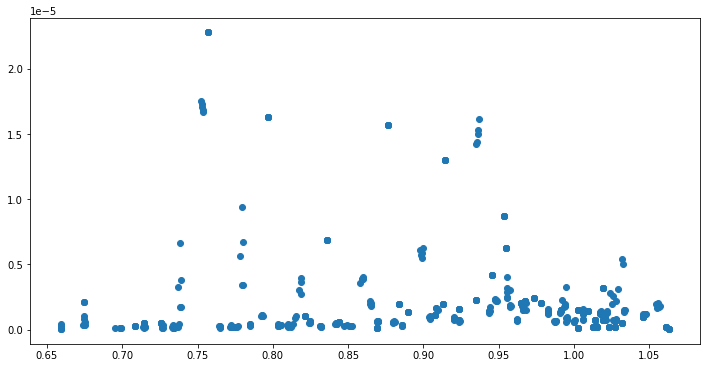

                            OLS Regression Results                            
Dep. Variable:                    mse   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     13.75
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           4.35e-26
Time:                        12:07:42   Log-Likelihood:                 5444.3
No. Observations:                 488   AIC:                        -1.086e+04
Df Residuals:                     474   BIC:                        -1.080e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.656e-06   1.44

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(obs_df['moneyness'], obs_df['mse'])
plt.show()

reg = obs_df.copy()

sheet_dummy = pd.get_dummies(reg['sheet'], prefix='sheet')
freq_dummy = pd.get_dummies(reg['freq'], prefix='freq')

reg_df = pd.concat([reg, sheet_dummy, freq_dummy], axis=1)
X = reg_df[['moneyness'] + list(freq_dummy.columns)[:-1]+ list(sheet_dummy.columns)[:-1]]
y = reg_df['mse']

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

## Effect of distance from ATM on MSE
- In the scatterplot, closer to ATM seem to have less variance
- Regression shows statistically significant positive effect of moneyness distance on MSE
- This means that both deep ITM and ATM options would have higher hedging error

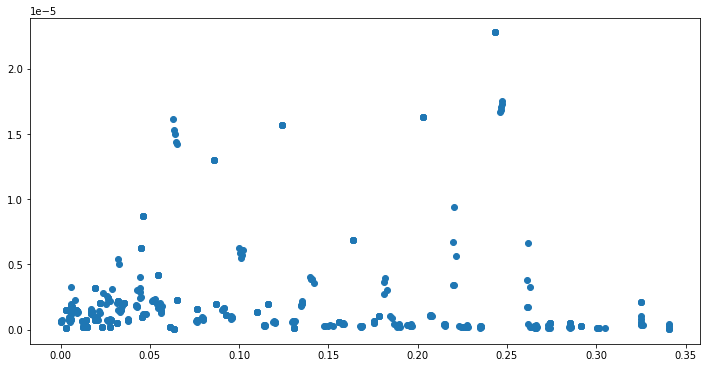

                            OLS Regression Results                            
Dep. Variable:                    mse   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     13.41
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           1.95e-25
Time:                        12:08:56   Log-Likelihood:                 5442.6
No. Observations:                 488   AIC:                        -1.086e+04
Df Residuals:                     474   BIC:                        -1.080e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                5.26e-07   6.25

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(obs_df['moneyness_distance'], obs_df['mse'])
plt.show()

X = reg_df[['moneyness_distance'] + list(freq_dummy.columns[:-1])+ list(sheet_dummy.columns[:-1])]
y = reg_df['mse']

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

## Controlling for ITM and OTM
- Same regression as before while controlling for is_OTM
- no statistically significant effect on how far out or in the money options are
- Significant effect for being OTM/ITM, such that OTM options are better hedge than ITM options as it decreases the MSE

In [23]:
X = reg_df[['moneyness_distance', 'is_OTM'] + list(freq_dummy.columns)[:-1]+ list(sheet_dummy.columns)[:-1]]
y = reg_df['mse']

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mse   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     13.18
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           2.01e-26
Time:                        12:08:59   Log-Likelihood:                 5446.6
No. Observations:                 488   AIC:                        -1.086e+04
Df Residuals:                     473   BIC:                        -1.080e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.121e-06   6.56